<a href="https://colab.research.google.com/github/RichardLiuCoding/Active-learning-in-microscopy/blob/AFM-dev/MOBO_DKL_RL_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by [Utkarsh Pratiush](https://github.com/utkarshp1161) and [Richard (Yu) Liu](https://github.com)
- Get in touch if any doubts or discussion [utkarshp1161@gmail.com]
- For reading related to this notebook please refer to [wilson et al 2016](https://arxiv.org/abs/1611.00336), [wilson et al 2015](https://arxiv.org/abs/1511.02222) and [Sebastian et al 2021](https://arxiv.org/abs/2102.12108)
- Reference to [Gpytorch example](https://docs.gpytorch.ai/en/v1.12/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html)


# Imports

In [1]:
import torch
import torch.nn as nn
from botorch.models.model import Model
from botorch.models.gpytorch import GPyTorchModel
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.optim import optimize_acqf
# from botorch.utils.multi_objective.box_decomposition import NondominatedPartitioning
from botorch.utils.sampling import sample_simplex
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.test_functions.multi_objective import BraninCurrin
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
torch.set_default_dtype(dtype)

print(device)


cuda


# Define MOBO-DKL

In [2]:
import gpytorch
from botorch.posteriors.gpytorch import GPyTorchPosterior
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import math
import torch.nn as nn
import numpy as np
from typing import Tuple, Optional, Dict, Union, List
import numpy as np
import torch

# Simple ConvNet for feature extraction
class ConvNetFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, output_dim=32):
        super(ConvNetFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.output_dim = output_dim
        self.fc = None  # Placeholder for the fully connected layer

    def forward(self, x):
        if len(x.shape) == 3: # TODO: hacky way to make sure botorch acquisition function works
            # flatten
            batch_size, channel, mn = x.shape[0], x.shape[1] , x.shape[2]
            d = math.sqrt(mn)      ## TODO: what if mn is not a perfect square?
            x = x.reshape(int(batch_size), int(channel), int(d), int(d))
        # Pass through the convolutional layers
        x = self.conv_layers(x)

        # If the fully connected layer is not defined yet, initialize it dynamically******************key
        if self.fc is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            device = x.device# TODO: better way to handle device
            self.fc = nn.Linear(flattened_size, self.output_dim).to(device)  # Create fc layer on the correct device

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# GP model with deep kernel using ConvNet feature extractor
class GPModelDKL(ApproximateGP):
    def __init__(self, inducing_points, likelihood, feature_extractor=None):
        if feature_extractor is None:
            feature_extractor = ConvNetFeatureExtractor(
                input_channels=1,  # Set according to your image channels
                output_dim=32      # Set as per the final feature dimension
            ).to(inducing_points.device)
        else:
            feature_extractor = feature_extractor.to(inducing_points.device)

        # Transform inducing points with ConvNet
        inducing_points = feature_extractor(inducing_points)

        # Variational setup
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )

        super(GPModelDKL, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.num_outputs = 1  # must be one
        self.likelihood = likelihood
        self.feature_extractor = feature_extractor

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, use_feature_extractor=True, *args, **kwargs):
        ## TODO: to make it compatible with botorch acquisition function we need it to make patches internally from flattened patches
        if use_feature_extractor:
            if len(x.shape) == 3:
                # flatten
                batch_size, channel, mn = x.shape[0], x.shape[1] , x.shape[2]
                d = math.sqrt(mn)      ## TODO: what if mn is not a perfect square?
                x = x.reshape(int(batch_size), int(channel), int(d), int(d))
            x = self.feature_extractor(x)
        return super().__call__(x, *args, **kwargs)

    def posterior(self, X, output_indices=None, observation_noise=False, *args, **kwargs) -> GPyTorchPosterior:
        self.eval()
        self.likelihood.eval()
        dist = self.likelihood(self(X))
        return GPyTorchPosterior(dist)

    @property
    def hparam_dict(self):
        return {
            "likelihood.noise": self.likelihood.noise.item(),
            "covar_module.base_kernel.outputscale": self.covar_module.base_kernel.outputscale.item(),
            "mean_module.constant": self.mean_module.constant.item(),
        }




In [3]:
from botorch.utils.multi_objective.pareto import is_non_dominated

def embeddings_and_predictions(model, patches, device="cpu") -> (torch.Tensor, torch.Tensor):
    """
    Get predictions from the trained model
    """
    model.eval()
    patches = patches.to(device)
    with torch.no_grad():
        predictions = model(patches)
        embeddings = model.feature_extractor(patches).view(patches.size(0), -1).cpu().numpy()
    return predictions, embeddings

def train_model(acquired_data, patches, feature_extractor,
                device="cpu", num_epochs=50, log_interval=5,
                scalarizer_zero=False) -> ApproximateGP:
    X_train = torch.stack([patches[idx] for idx in acquired_data]).to(device)
    y_train = torch.tensor(list(acquired_data.values()), dtype=dtype).to(device)
    if scalarizer_zero:
        y_train = torch.zeros_like(y_train)

    else:
        # Normalize y_train
        y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    # Use the first 10 points in the feature space to pre-train the GP model
    inducing_points = X_train[:10]
    model = GPModelDKL(inducing_points=inducing_points, likelihood=likelihood, feature_extractor=feature_extractor).to(device)

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # for epoch in tqdm(range(1, num_epochs + 1), desc="Training Progress"):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X_train)


        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()

    return model

In [4]:
# def train_mobo_model()

# Load the simulated data

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# from tqdm import tqdm
import aespm as ae

In [6]:
def load_image_and_features(img: np.ndarray , window_size : int) -> (np.ndarray, np.ndarray):
    coordinates = ae.tools.get_coord_grid(img, step=1, return_dict=False)
    features_all, coords, _ = ae.tools.extract_subimages(img, coordinates, window_size)
    features_all = features_all[:, :, :, 0]
    coords = np.array(coords, dtype=int)
    norm_ = lambda x: (x - x.min()) / np.ptp(x) # or use:  norm_ = lambda x: (x - np.min(x)) / np.ptp(x) --> numpy-2.0 upgrade
    features = norm_(features_all)
    return features, coords# shapes (3366, 5, 5) and (3366, 2)

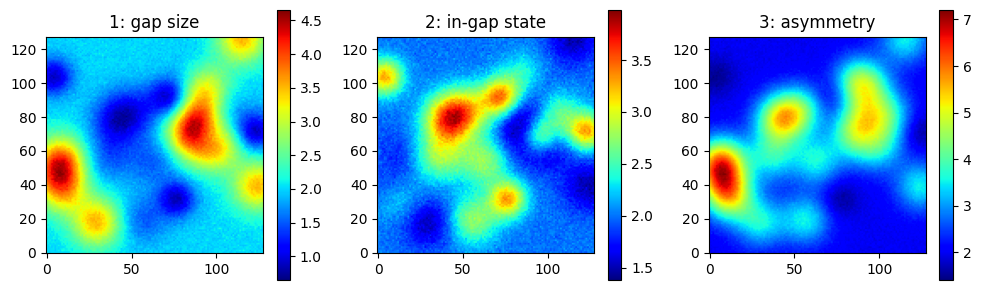

In [7]:
data = np.load('../../data/mobo_dkl_data2.npz')

topo = data['topo'][::2, ::2]
rewards = data['rewards']

rewards_new = []

for i in range(len(rewards)):
    rewards_new.append(rewards[i][::2, ::2])

rewards = rewards_new

titles = ['1: gap size', '2: in-gap state', '3: asymmetry']
img = []

fig, ax = plt.subplots(1,3, figsize=[10, 3])
for i in range(3):
    img.append(ax[i].imshow(rewards[i], origin='lower', cmap=plt.cm.jet))
    plt.colorbar(img[i], ax=ax[i])
    ax[i].set_title(titles[i])

plt.tight_layout()

12769

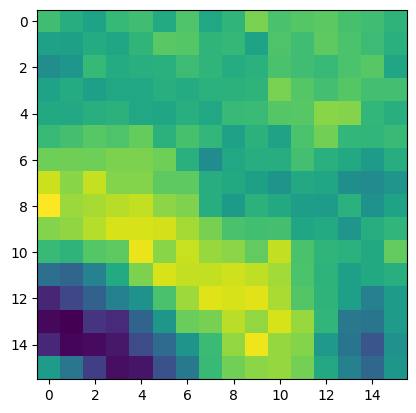

In [8]:
ws = 16

features, indices_all = load_image_and_features(topo, ws)

plt.imshow(features[30])
len(features)

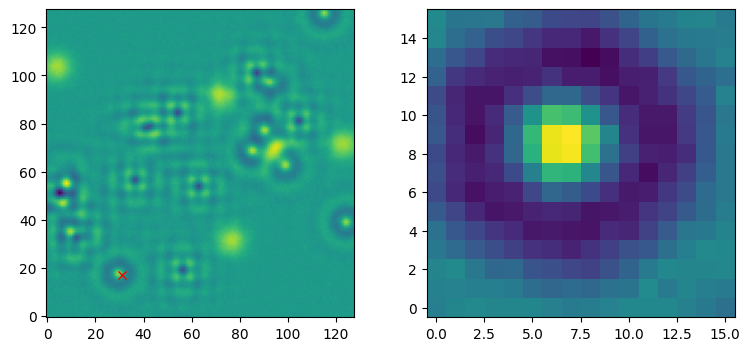

In [9]:
index = 1040

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')

In [10]:
def normalize_data(data : np.ndarray) -> np.ndarray:  # Expected data type: torch.Tensor
    """Normalize data to the [0, 1] range."""
    return (data - data.min()) / (data.max() - data.min())

norm_ = lambda x: (x-x.min) / (x.max()-x.min())

def numpy_to_torch_for_conv(np_array) -> torch.Tensor:
    """
    Converts a NumPy array of shape (batch_size, a, b) to a PyTorch tensor
    with shape (batch_size, 1, a, b) for neural network use.

    Parameters:
        np_array (np.ndarray): Input NumPy array of shape (batch_size, a, b).

    Returns:
        torch.Tensor: Converted PyTorch tensor of shape (batch_size, 1, a, b).
    """
    # Check if input is a numpy array
    if not isinstance(np_array, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    # Convert to PyTorch tensor and add a channel dimension
    # tensor = torch.from_numpy(np_array, dtype=torch.double)  # Convert to float tensor
    tensor = torch.tensor(np_array, dtype=dtype)  # Convert to float tensor
    tensor = tensor.unsqueeze(1)  # Add a channel dimension at index 1

    return tensor

def calculate_rewards(unacquired_indices, indices_all, fn=None, data=None):
    rew = []
    for i in unacquired_indices:
        x, y = indices_all[i]
        # spec = data[x,y]
        # rew.append(fn(bias, spec))
        rew.append(data[fn][x, y])
    return torch.tensor(rew)

def update_acquired(acquired_data, unacquired_indices, selected_indices, indices_all, fn=None, data=None) -> (np.array, list):
    for idx in selected_indices:# TODO: It queries the black box everytime on already acquired points:
        x, y = indices_all[idx]
        # spec = data[x,y]
        # acquired_data[idx] = fn(bias, spec)
        acquired_data[idx] = data[fn][x, y]
    unacquired_indices = [idx for idx in unacquired_indices if idx not in selected_indices]
    return acquired_data, unacquired_indices

from botorch.utils.multi_objective.pareto import is_non_dominated

# def plot_pareto_predictions()

def plot_pareto_front(acquired_data1, acquired_data2, step, save_path=None):
    """
    Plot the current Pareto front based on acquired data from both objectives and return Pareto indices.

    Args:
        acquired_data1 (dict): Acquired data for Objective 1. Format: {index: value1}
        acquired_data2 (dict): Acquired data for Objective 2. Format: {index: value2}
        step (int): Current BO step.
        save_path (str, optional): Path to save the plot. If None, displays the plot.

    Returns:
        list: List of indices that are Pareto optimal.
    """
    if not acquired_data1 or not acquired_data2:
        print("Insufficient data to plot Pareto front.")
        return []

    # Ensure both acquired_data1 and acquired_data2 have the same indices
    common_indices = list(set(acquired_data1.keys()).intersection(set(acquired_data2.keys())))
    if not common_indices:
        print("No common indices between acquired_data1 and acquired_data2 for Pareto front plotting.")
        return []

    # Extract objective values
    obj1 = np.array([acquired_data1[idx] for idx in common_indices])
    obj2 = np.array([acquired_data2[idx] for idx in common_indices])

    obj1= (obj1 - obj1.min()) / (obj1.max() - obj1.min())######## normalized
    obj2= (obj2 - obj2.min()) / (obj2.max() - obj2.min())######## normalized


    # Combine objectives into a single array
    objectives = np.stack([obj1, obj2], axis=1)
    objectives_tensor = torch.tensor(objectives, dtype=dtype)

    # Determine Pareto optimal points using BoTorch's is_non_dominated
    pareto_mask = is_non_dominated(objectives_tensor)

    # Extract Pareto optimal points
    pareto_obj1 = obj1[pareto_mask.numpy()]
    pareto_obj2 = obj2[pareto_mask.numpy()]

    # Extract Pareto optimal indices
    pareto_indices = [common_indices[i] for i, is_pareto in enumerate(pareto_mask.numpy()) if is_pareto]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(obj1, obj2, label='Acquired Points', color='blue')
    plt.scatter(pareto_obj1, pareto_obj2, label='Pareto Front', color='red')

    # Optionally, annotate Pareto points with their indices
    for idx, x, y in zip(pareto_indices, pareto_obj1, pareto_obj2):
        plt.annotate(str(idx), (x, y), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title(f'Pareto Front after BO Step {step +1}')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        plt.show()
        plt.close()
    else:
        plt.show()
        plt.close()


    return pareto_indices

In [11]:
def plot_pareto_front(img, unacquired, predictions_data, acquired_data1,acquired_data2, acq):

    seed_indices = np.array(predictions_data["seed_indices"])  # Initial sampled indices (referring to positions in indices_all)
    num_seed = len(seed_indices)
    unacquired_indices = np.array(predictions_data["unacquired_indices"])  # Remaining indices
    indices_all = np.array(predictions_data["indices_all"])  # All possible indices (coordinates)
    # Map seed_indices and unacquired_indices to their coordinates in indices_all
    seed_coords = indices_all[seed_indices]
    unacquired_coords = indices_all[unacquired_indices]
    # Calculate acquired indices as the complement of unacquired and seed indices
    acquired_indices = np.setdiff1d(np.arange(indices_all.shape[0]), np.union1d(seed_indices, unacquired_indices), assume_unique=True)
    acquired_coords = indices_all[acquired_indices]

    X_candidates = np.array(indices_all[unacquired])

    res1 = list(acquired_data1.values())
    res2 = list(acquired_data2.values())
    titles = ['DKL Trajectory', 'Acquisition', 'Pareto Front']
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), dpi=200)
    ax[0].imshow(img, cmap="gray", origin="lower")
    ax[0].scatter(seed_coords[:, 1], seed_coords[:, 0], c="b", label="Seed Points", marker="o")
    time_order = np.arange(len(acquired_coords))  # Create a sequence representing time
    scatter = ax[0].scatter(acquired_coords[:, 1], acquired_coords[:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")
    ax[0].legend()

    # ax[1].scatter(X_candidates[:,1], X_candidates[:,0], c=acq.cpu().detach().numpy(), cmap=plt.cm.jet)
    im1 = ax[1].scatter(X_candidates[:,1], X_candidates[:,0], c=acq, cmap=plt.cm.jet)

    ax[2].scatter(res1[:num_seed], res2[:num_seed], c='k')
    im2 = ax[2].scatter(res1[num_seed:], res2[num_seed:], c=np.arange(len(acquired_data1)-num_seed), cmap=plt.cm.jet)
    ax[2].set_xlabel('Reward 1')
    ax[2].set_ylabel('Reward 2')

    for i, axis in enumerate(ax):
        axis.set_title(titles[i])

    plt.colorbar(im1, ax=ax[1])
    plt.colorbar(im2, ax=ax[2])
    plt.tight_layout()
    plt.show()



In [12]:
seed = 35
num_seed = 10

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [13]:
patches = numpy_to_torch_for_conv(features)
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor1 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)
feature_extractor2 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)
feature_extractor3 = ConvNetFeatureExtractor(input_channels=1, output_dim=2).to(device)

acquired_data1 = {}
acquired_data2 = {}
acquired_data3 = {}

unacquired_indices1 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all
unacquired_indices2 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all
unacquired_indices3 = list(range(len(indices_all)))####### TODO: need to change later to use the indices_all


selected_indices1 = random.sample(unacquired_indices1, num_seed)
selected_indices2 = selected_indices1
selected_indices3 = selected_indices1

seed_indices = selected_indices1

true_scalarizer1= calculate_rewards(unacquired_indices1, indices_all,  fn=0, data=rewards)
true_scalarizer1= (true_scalarizer1 - true_scalarizer1.min()) / (true_scalarizer1.max() - true_scalarizer1.min())######## normalized
true_scalarizer2= calculate_rewards(unacquired_indices2, indices_all, fn=1, data=rewards)
true_scalarizer2= (true_scalarizer2 - true_scalarizer2.min()) / (true_scalarizer2.max() - true_scalarizer2.min())######## normalized
true_scalarizer3= calculate_rewards(unacquired_indices3, indices_all, fn=2, data=rewards)
true_scalarizer3= (true_scalarizer3 - true_scalarizer3.min()) / (true_scalarizer3.max() - true_scalarizer3.min())######## normalized


acquired_data3, unacquired_indices3 = update_acquired(acquired_data3, unacquired_indices3, selected_indices3, indices_all, fn=2, data=rewards)
acquired_data2, unacquired_indices2 = update_acquired(acquired_data2, unacquired_indices2, selected_indices2, indices_all, fn=1, data=rewards)
acquired_data1, unacquired_indices1 = update_acquired(acquired_data1, unacquired_indices1, selected_indices1, indices_all, fn=0, data=rewards)



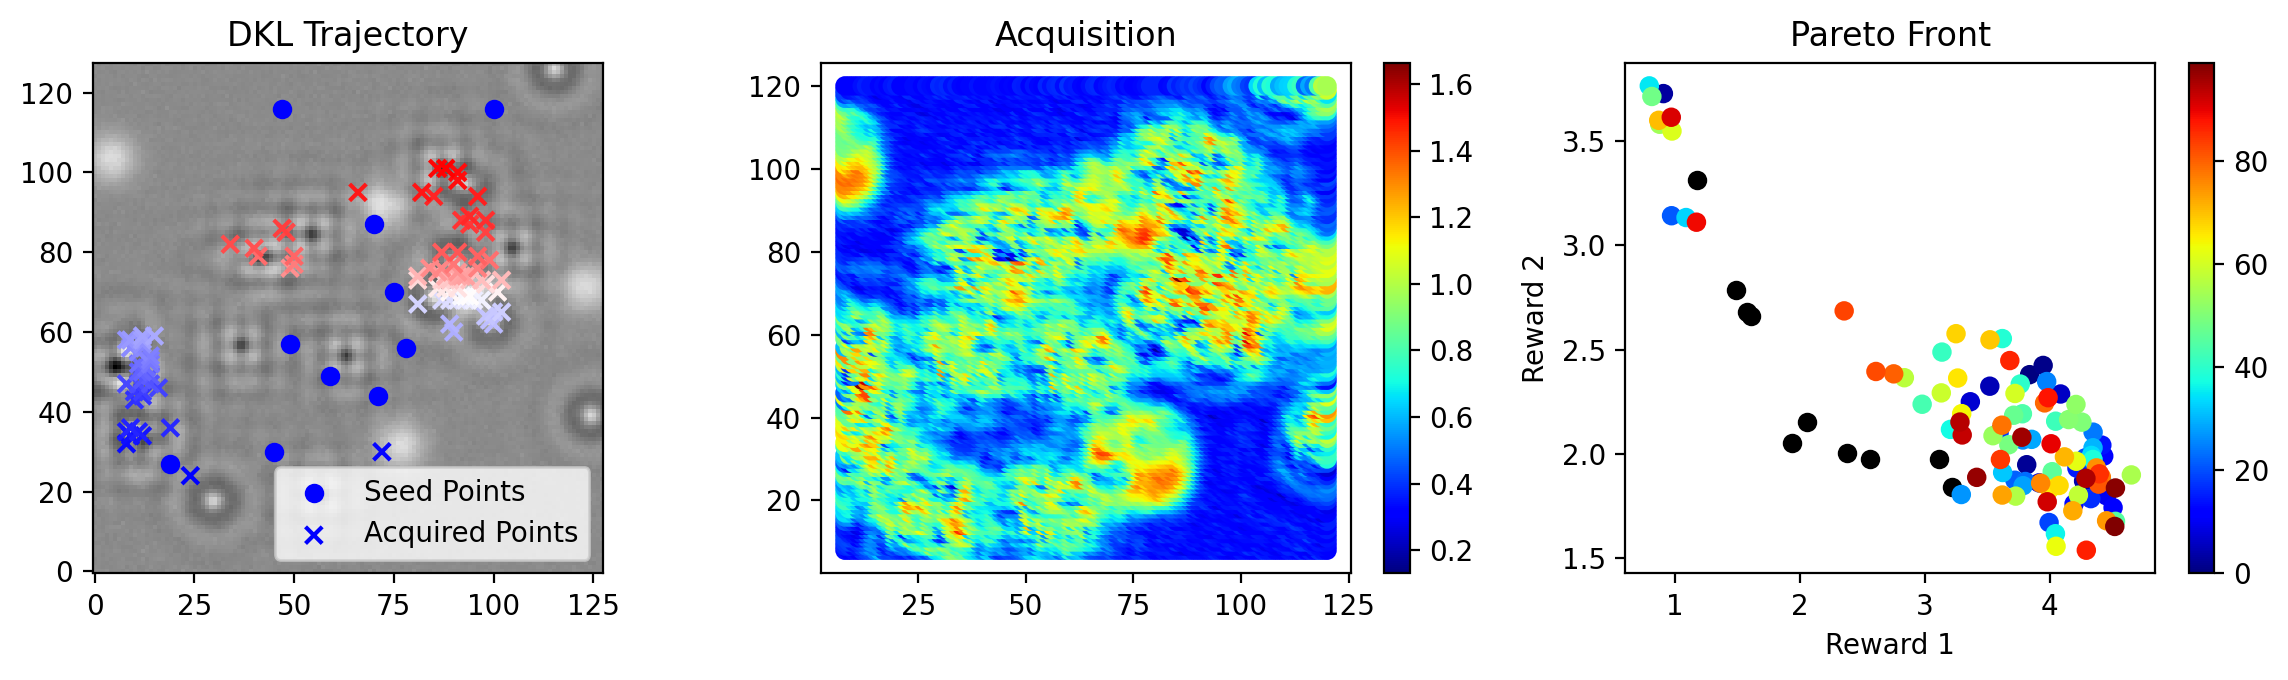

In [14]:
budget = 100
num_epochs = 200
scalarizer_zero = False

window_size = ws

Active_learning_statistics = {}
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound #ExpectedImprovement


# Start Bayesian Optimization loop
for step in range(budget):
    mean_y_pred_mean_al = []
    mean_y_pred_variance_al = []
    mae_list = []
    nlpd_list = []

    # Train the DKL model
    model1 = train_model(acquired_data1, patches, feature_extractor1, device=device, num_epochs=num_epochs, scalarizer_zero=scalarizer_zero)
    model2 = train_model(acquired_data2, patches, feature_extractor2, device=device, num_epochs=num_epochs, scalarizer_zero=scalarizer_zero)
    model1.eval()
    model2.eval()
    # Wrap the model and likelihood in the BoTorch model ------> Ithink not needed as have approxiamateGP--> check later
    # Prepare candidate set (unacquired patches)
    candidate_indices = unacquired_indices1
    X_candidates = torch.stack([patches[idx] for idx in candidate_indices]).to(device)
    X_candidates_flat = X_candidates.reshape(X_candidates.size(0), -1)  # Flatten patches for distance calculation
    # X_candidates = X_candidates.reshape(-1, window_size*window_size)# TODO: to make botorch acquisition functions compatible-> optimize_acqf_discrete
    X_candidates = X_candidates.reshape(-1, 1, window_size*window_size) # Note this is when using acq f:n directly and not invoking  optimize_acqf_discrete
    # as we are normalizing the y_values in the train_model function:y_train = (y_train - y_train.min()) / (y_train.max() - y_train.min())
    # TODO: make it better -> Note we dont normalize entire data as we dont have access to entire spectrum image early on --> so just on seed points
    y_train1 = torch.tensor(list(acquired_data1.values()), dtype=dtype).to(device)
    y_train1 = (y_train1 - y_train1.min()) / (y_train1.max() - y_train1.min())
    y_train2 = torch.tensor(list(acquired_data2.values()), dtype=dtype).to(device)
    y_train2 = (y_train2 - y_train2.min()) / (y_train2.max() - y_train2.min())
    acq_func1 = LogExpectedImprovement(model=model1, best_f=y_train1.max().to(device))
    acq_func2 = LogExpectedImprovement(model=model2, best_f=y_train2.max().to(device))

    # acq_func1 = UpperConfidenceBound(model=model1, beta=100)
    # acq_func2 = UpperConfidenceBound(model=model2, beta=100)

    acq_values1 = acq_func1(X_candidates)
    acq_values2 = acq_func2(X_candidates)

    # acq_values1 = norm_(acq_values1)
    # acq_values2 = norm_(acq_values2)

    acq_values1 = (acq_values1 - acq_values1.min()) / (acq_values1.max() - acq_values1.min())
    acq_values2 = (acq_values2 - acq_values2.min()) / (acq_values2.max() - acq_values2.min())

    # --- Add penalty for nearby points ---
    # Get the features of already acquired points
    acquired_indices = list(acquired_data1.keys())
    acquired_features = torch.stack([patches[idx] for idx in acquired_indices]).to(device)
    acquired_features_flat = acquired_features.reshape(acquired_features.size(0), -1)
    # Initialize penalties
    penalties = torch.zeros_like(acq_values1).to(device)
    if len(acquired_indices) > 0:  # Only apply penalty if there are acquired points
        # Calculate pairwise distances between candidates and acquired points
        # Using a more numerically stable distance calculation
        candidates_norm = (X_candidates_flat ** 2).sum(dim=1, keepdim=True)  # [n_candidates, 1]
        acquired_norm = (acquired_features_flat ** 2).sum(dim=1, keepdim=True).t()  # [1, n_acquired]
        # Calculate the dot product
        dot_product = torch.mm(X_candidates_flat, acquired_features_flat.t())  # [n_candidates, n_acquired]
        # Calculate squared distances
        squared_distances = candidates_norm + acquired_norm - 2 * dot_product  # [n_candidates, n_acquired]
        # Find minimum distance for each candidate point
        min_distances, _ = torch.min(squared_distances, dim=1)  # [n_candidates]
        # Convert to penalties: high penalty for small distances
        threshold = 1e-6
        min_distances = torch.clamp(min_distances, min=threshold)
        # Scale the penalties - adaptive scaling based on data distribution
        proximity_scale = torch.mean(min_distances) * 0.5  # Adjust this value to control penalty strength
        penalties = torch.exp(-min_distances / proximity_scale)
    # Apply penalties to acquisition values
    penalty_weight = 0.3  # Controls the importance of diversity vs. exploitation
    acq_values1_penalized = acq_values1 - penalty_weight * penalties
    acq_values2_penalized = acq_values2 - penalty_weight * penalties

    acq = acq_values1_penalized.cpu().detach().numpy() + acq_values2_penalized.cpu().detach().numpy()

    # Stack acquisition values into a single tensor of shape (Q, 2)
    acq_matrix = torch.stack([acq_values1_penalized, acq_values2_penalized], dim=1)
    # Determine Pareto optimal points
    pareto_mask = is_non_dominated(acq_matrix)
    # Convert mask to boolean numpy array
    pareto_mask_np = pareto_mask.cpu().numpy()
    # Extract Pareto optimal indices
    pareto_indices = np.where(pareto_mask_np)[0]
    if len(pareto_indices) == 0:
        # If no Pareto optimal points, fallback to selecting the point with the highest acq_1
        selected_candidate_idx = torch.argmax(acq_values1_penalized).item()
    else:
        # Extract acquisition values for Pareto optimal points
        pareto_acq1 = acq_values1_penalized[pareto_mask]
        pareto_acq2 = acq_values2_penalized[pareto_mask]
        # Compute aggregate acquisition value (e.g., sum or average)
        aggregate_acq = pareto_acq1 + pareto_acq2  # Simple sum; can also use weighted sum or average
        # Select the Pareto point with the highest aggregate acquisition value
        selected_pareto_idx = torch.argmax(aggregate_acq).item()
        selected_candidate_idx = pareto_indices[selected_pareto_idx]
    # Map the selected candidate index to the original dataset index
    selected_index = candidate_indices[selected_candidate_idx]
    selected_indices = [selected_index]  # can be multiple indices if batch acquisition

    unacquired_indices1_temp = np.copy(unacquired_indices1)

    # Update acquired data with new observations
    acquired_data1, unacquired_indices1 = update_acquired(acquired_data1, unacquired_indices1, selected_indices, indices_all,  fn=0, data=rewards)
    acquired_data2, unacquired_indices2 = update_acquired(acquired_data2, unacquired_indices2, selected_indices, indices_all,  fn=1, data=rewards)
    # pareto_indices = plot_pareto_front(acquired_data1, acquired_data2, step, save_path=None)
    print(f"**************************done BO step {step +1}", end='\r')



    # print("total points in pareto_indices",len(pareto_indices))
    # Save predictions as a .pkl file
    Active_learning_statistics = {
        "img": img,
        "features": features,
        "indices_all": np.array(indices_all),
        "seed_indices": np.array(seed_indices),
        "unacquired_indices": np.array(unacquired_indices1),
        "mean_y_pred_mean_al": np.array(mean_y_pred_mean_al),
        "mean_y_pred_variance_al": np.array(mean_y_pred_variance_al)
        # "mae": np.array(mae_list),
        # "nlpd": np.array(nlpd_list)
                }
    plot_pareto_front(topo, unacquired_indices1_temp, Active_learning_statistics, acquired_data1,acquired_data2, acq)

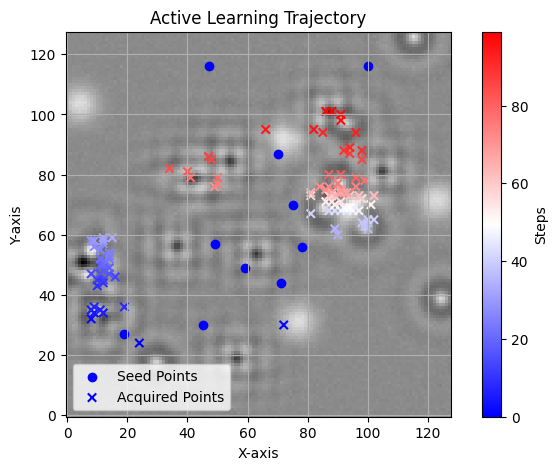

In [15]:
##############################-> plot
predictions_data = Active_learning_statistics
# Extract necessary data
# img = np.array(predictions_data["img"])  # Image or grid for background visualization
img = topo
seed_indices = np.array(predictions_data["seed_indices"])  # Initial sampled indices (referring to positions in indices_all)

unacquired_indices = np.array(predictions_data["unacquired_indices"])  # Remaining indices
indices_all = np.array(predictions_data["indices_all"])  # All possible indices (coordinates)
# Map seed_indices and unacquired_indices to their coordinates in indices_all
seed_coords = indices_all[seed_indices]
unacquired_coords = indices_all[unacquired_indices]
# Calculate acquired indices as the complement of unacquired and seed indices
acquired_indices = np.setdiff1d(np.arange(indices_all.shape[0]), np.union1d(seed_indices, unacquired_indices), assume_unique=True)
acquired_coords = indices_all[acquired_indices]
# Plot the results
plt.figure(figsize=(8, 5))
# Display the image or grid as the background
plt.imshow(img, cmap="gray", origin="lower")
# Plot the seed points in blue
plt.scatter(seed_coords[:, 1], seed_coords[:, 0], c="b", label="Seed Points", marker="o")
time_order = np.arange(len(acquired_coords))  # Create a sequence representing time
scatter = plt.scatter(acquired_coords[:, 1], acquired_coords[:, 0], c=time_order, cmap="bwr", label="Acquired Points", marker="x")
# Plot the unacquired points in green
# plt.scatter(unacquired_coords[:, 1], unacquired_coords[:, 0], c="g", label="Unacquired Points", marker="+")
# Set plot labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Active Learning Trajectory")
plt.legend()
plt.grid(True)
# Add a colorbar and label it as "Steps"
cbar = plt.colorbar(scatter)
cbar.set_label("Steps")
# plt.savefig(Path(res_dir) / "AL_traj.png")
plt.show()
plt.close()


Text(0, 0.5, 'Reward 2')

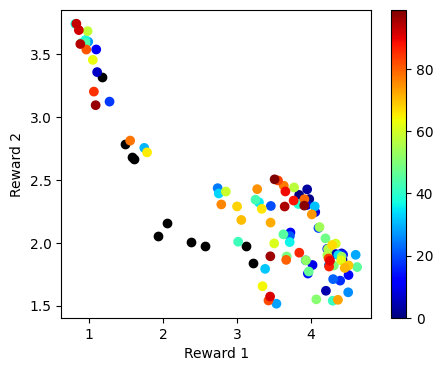

In [ ]:
res1 = list(acquired_data1.values())
res2 = list(acquired_data2.values())

plt.figure(figsize=[5,4])
plt.scatter(res1[:10], res2[:10], c='k')
im = plt.scatter(res1[10:], res2[10:], c=np.arange(len(acquired_data1)-10), cmap=plt.cm.jet)


plt.colorbar(im, ax=plt.gca())
plt.xlabel('Reward 1')
plt.ylabel('Reward 2')


Text(0.5, 1.0, 'Predicted Reward 2')

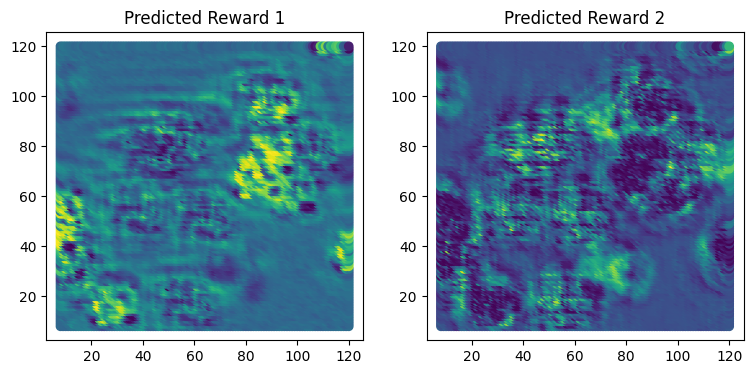

In [ ]:
import matplotlib.pyplot as plt
pred1, embeddings1 = embeddings_and_predictions(model1, patches, device)
pred2, embeddings2 = embeddings_and_predictions(model2, patches, device)

# plt.figure(figsize=[4,4])
# plt.scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=pred1.mean.cpu().numpy())
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=pred2.mean.cpu().numpy())

ax[0].set_title('Predicted Reward 1')
ax[1].set_title('Predicted Reward 2')


In [ ]:
indices_all.shape

(12769, 2)

In [ ]:
embeddings2.shape

(12769, 2)

In [ ]:
embeddings1.shape

(12769, 2)

Text(0.5, 1.0, 'Embeddings 2')

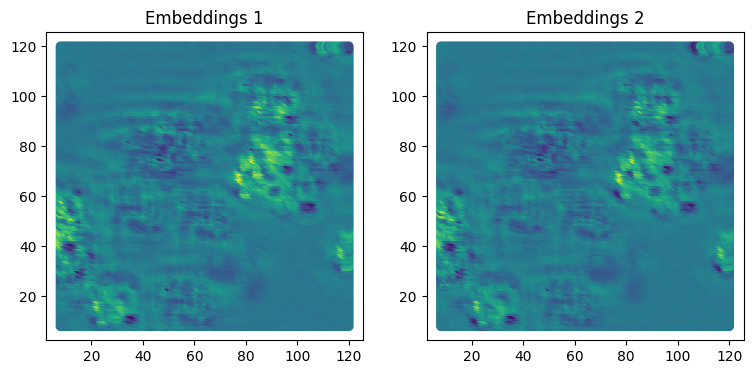

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 0])
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 1])

ax[0].set_title('Embeddings 1')
ax[1].set_title('Embeddings 2')

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=[9,4])
# ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 2])
# # ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
# ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings1[:, 3])

# ax[0].set_title('Embeddings 3')
# ax[1].set_title('Embeddings 4')

Text(0.5, 1.0, 'Embeddings 2')

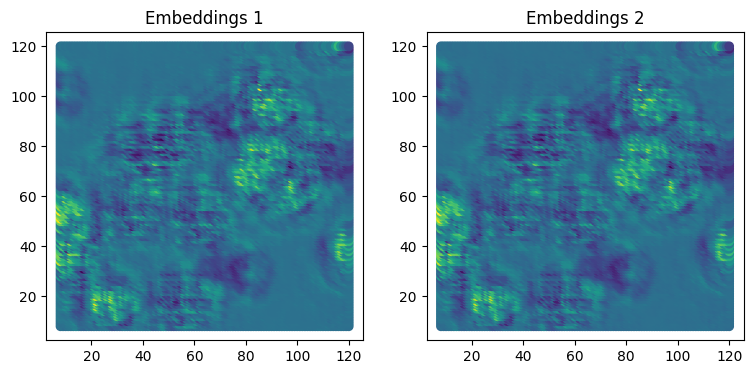

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 0])
# ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 1])

ax[0].set_title('Embeddings 1')
ax[1].set_title('Embeddings 2')

# fig, ax = plt.subplots(1,2, figsize=[9,4])
# ax[0].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 2])
# # ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
# ax[1].scatter(indices_all[:,1], indices_all[:,0], c=embeddings2[:, 3])

# ax[0].set_title('Embeddings 3')
# ax[1].set_title('Embeddings 4')

In [ ]:
torch.cuda.empty_cache()

# Active learning Functions

In [ ]:
ws = 16

features, indices_all = load_image_and_features(topo, ws)

plt.imshow(features[30])
len(features)

index = 1040

fig, ax = plt.subplots(1,2, figsize=[9,4])
ax[0].imshow(topo, origin='lower')
ax[0].plot(indices_all[index][1], indices_all[index][0], 'rx')
ax[1].imshow(features[index], origin='lower')

In [ ]:
exp.update_param('feature_all', features)

In [ ]:
def measure(self, ):


exp.add_func(measure)

In [ ]:
def generate_seeding(self, num=10):


exp.add_func(generate_seeding)

In [ ]:
def train_model(self, acq='EI'):

exp.add_func(train_mobo)

In [ ]:
def avtive_learn(self, num=50):

exp.add_func(avtive_learn)

# Initiate parameters

In [ ]:
save = ''
patches = numpy_to_torch_for_conv(features)
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the grid-data